# sourmash, mash and CMash comparison

(the smol gather experiment)

This experiment compares sourmash scaled signatures, CMash and mash screen for containment queries.
All sketches are for `k=21`. sourmash signatures are calculated with `scaled=1000`, CMash and mash screen use `n=1000` for their sketches.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image

## Loading data

Loading three dataframes, one for each method. Harmonize filenames so we can merge the dataframes further down in the analysis.

### sourmash

Using the `f_match` column (how much of the found genome is contained in the metagenome).

In [2]:
sourmash_g = pd.read_table("../outputs/scaled_1000/SRR606249.csv",
                         sep=",",
                         usecols=["f_match", "filename"])
sourmash_g.columns = ("sourmash_g", "filename")
sourmash_g["filename"] = sourmash_g["filename"].str.replace(r".*/(?P<id>\d+).sig", lambda m: m.group("id") + ".fa")
sourmash_g.set_index("filename", inplace=True)

In [3]:
sourmash_c = pd.read_table("../outputs/scaled_1000/containments_SRR606249.csv",
                         sep=",",
                         usecols=["containment", "filename"])
sourmash_c.columns = ("sourmash_c", "filename")
sourmash_c.set_index("filename", inplace=True)

### CMash

CMash outputs the filename and containment for each match.

In [4]:
cmash = pd.read_table("../outputs/cmash/SRR606249.csv",
                      sep=",",
                      names=("filename", "cmash"),
                      header=0)
cmash.set_index("filename", inplace=True)

### mash

`mash screen` outputs containment in the first column, and again harmonizing filename to be able to join dataframes later.

Since `mash sketch` has a cutoff parameter `-m` that can be used to discard k-mers below the cutoff during sketch construction, I tried using `-m 1` and `-m 2` to see if there are differences:

In [5]:
mash_m2 = pd.read_table("../outputs/mash_screen/SRR606249-k21-s1000-m2.tsv",
                            header=None,
                            names=("mash_m2", "hashes", "median abundance", "p-value", "filename", "description"),
                            usecols=["filename", "mash_m2"])
mash_m2["filename"] = mash_m2["filename"].str.replace(".*/", "")
mash_m2.set_index("filename", inplace=True)

In [6]:
mash_m1 = pd.read_table("../outputs/mash_screen/SRR606249-k21-s1000-m1.tsv",
                            header=None,
                            names=("mash_m1", "hashes", "median abundance", "p-value", "filename", "description"),
                            usecols=["filename", "mash_m1"])
mash_m1["filename"] = mash_m1["filename"].str.replace(".*/", "")
mash_m1.set_index("filename", inplace=True)

If we plot a histogram of the differences we see that most results agree (on the containment measure), so using `-m 1` from now on (which also matches the default sourmash and CMash behavior).

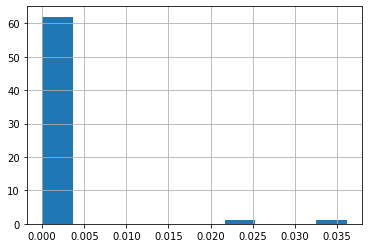

In [7]:
with pd.option_context('display.max_rows', None):
    display((mash_m1["mash_m1"] - mash_m2["mash_m2"]).abs().sort_values().hist())

## Containment checks

Merging the three dataframes, and since the `containment` for each method is in a column with the method name, it is easy to get the proper labels for plotting later.

In [8]:
#all_methods = pd.concat((cmash, mash_m1, sourmash_c, sourmash_g), axis=1)
all_methods = pd.concat((cmash, mash_m1, sourmash_c), axis=1)

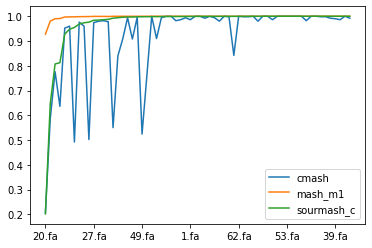

In [9]:
all_methods.sort_values(by="sourmash_c").plot()

mash containment is always above .95, but it is hard to visualize what is happening in this graph. Let's try to use a table, and filter out results where they agree (where "agree" is at most 5% difference in containment):

In [10]:
def highlight_median(s):
    diff = np.abs(s - np.median(s))
    colorized = []
    for v in diff:
        if v < .05: colorized.append('background-color: white')
        elif v < .1: colorized.append('background-color: yellow')
        elif v < .3: colorized.append('background-color: orange')
        else: colorized.append('background-color: red')
    return colorized

with pd.option_context('display.max_rows', None, 'show_dimensions', True):
    df = all_methods.sort_values(by="sourmash_c")
    df = df[df.apply(lambda x: any(np.abs(x - x.median()) > .05), axis=1)]
    display(df.style.apply(highlight_median, axis=1))

,cmash,mash_m1,sourmash_c
20.fa,0.206000,0.927528,0.201496
19.fa,0.586000,0.980124,0.646635
55.fa,0.776000,0.989899,0.807190
17.fa,0.636000,0.990767,0.812327
58.fa,0.492000,0.997610,0.954842
16.fa,0.502000,0.998746,0.976103
23.fa,0.550000,0.999713,0.992238
34.fa,0.840000,0.999809,0.994126
33.fa,0.908000,0.999857,0.996024
5.fa,0.908000,0.999809,0.996885


## Similarity and Containment matrices

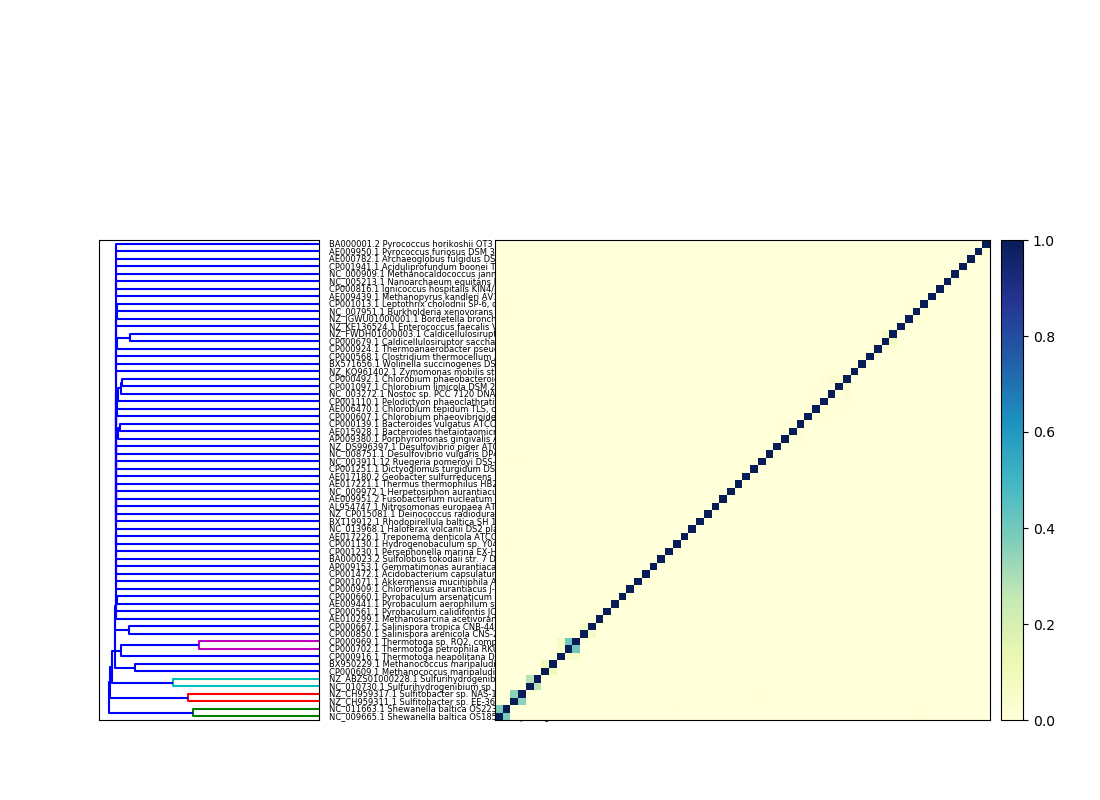

In [11]:
Image("../outputs/scaled_1000/similarity.dist.matrix.png")

## Median abundance (sourmash and mash)

mash also calculates abundance for each hash, so we can compare the median abundance reported by both mash and sourmash.

In [12]:
mash_screen = pd.read_table("../outputs/mash_screen/SRR606249-k21-s1000-m1.tsv",
                            header=None,
                            names=("mash", "hashes", "median abundance mash", "p-value", "filename", "description"),
                           usecols=("mash", "median abundance mash", "filename"))
mash_screen["filename"] = mash_screen["filename"].str.replace(".*/", "")
mash_screen.set_index("filename", inplace=True)

In [13]:
sourmash = pd.read_table("../outputs/scaled_1000/SRR606249.csv",
                         sep=",",
                         usecols=["f_match", "median_abund", "filename"]
                        )
sourmash.columns = ("sourmash", "median abundance sourmash", "filename")
sourmash["filename"] = sourmash["filename"].str.replace(r".*/(?P<id>\d+).sig", lambda m: m.group("id") + ".fa")
sourmash.set_index("filename", inplace=True)

Keeping only result where the difference in median abundance is at least 1. Also highlighting differences:
 - <span style="color: RGBA(171, 145, 68, 1)">median abundance difference > 10</span>
 - <span style="color: darkred">median abundance difference > 30</span>
 - large containment differences (>0.05): gradient background

In [14]:
def highlight_diff(s):
    mdiff = np.abs(s["median abundance mash"] - s["median abundance sourmash"])
    cdiff = np.abs(s["mash"] - s["sourmash"])

    gradient_bg = 'background: repeating-linear-gradient(45deg, rgba(0, 0, 0, 0.2), rgba(0, 0, 0, 0.2) 10px, rgba(0, 0, 0, 0.3) 10px, rgba(0, 0, 0, 0.3) 20px);'
    bg = ''
    if cdiff >= 0.05: 
        bg = gradient_bg
    
    if mdiff == 1: color = 'background-color: white'
    elif mdiff < 10: color = 'background-color: yellow'
    else: color = 'background-color: red; color:white'
    
    return [bg + color] * 4

abundances = pd.concat((mash_screen, sourmash), axis=1)
with pd.option_context('display.max_rows', None, 'show_dimensions', True):
    diff = abundances["median abundance mash"] - abundances["median abundance sourmash"]
    display(abundances[diff.abs() >= 1].style.apply(highlight_diff, axis=1))

,mash,median abundance mash,sourmash,median abundance sourmash
3.fa,0.999952,49,0.999048,48.000000
9.fa,1.000000,14,0.909419,13.000000
12.fa,1.000000,33,0.987080,32.000000
20.fa,0.927528,8,0.200094,7.000000
22.fa,1.000000,29,0.997862,30.000000
23.fa,0.999713,9,0.990486,10.000000
25.fa,1.000000,36,0.998037,37.000000
26.fa,1.000000,10,0.998445,9.000000
30.fa,1.000000,17,0.863339,16.000000
33.fa,0.999857,109,0.994036,110.000000
